In [17]:
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

Import Dataframe with Closing prices for all stocks 01-09-2016 to 18-07-2017
Drop Stocks not traded everyday

In [2]:
df = pd.read_csv('all_stock_df.csv', index_col ='Date', parse_dates=True)
df = df.dropna(axis=1)

Generate the daily returns dataframe

In [3]:
daily_ret = df.copy()
daily_ret.ix[1:,:] = (df.ix[1:,:]/df.ix[:-1,:].values) - 1
daily_ret.ix[0,:] = 0

# Make adjustments for same closing price consecutively
daily_ret.fillna(0,inplace=True)

daily_ret.head(n=10)

,NIFTY,20MICRONS,3IINFOTECH,3MINDIA,AARTIDRUGS,AARTIIND,AARVEEDEN,ABAN,ABB,ABBOTINDIA,...,MAXINDIA,ADVENZYMES,LSIL,MINDTECK,NLCINDIA,DBL,HSCL,SITINET,SPAL,RBLBANK
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-02-09,0.003989,0.031680,0.019802,0.008537,-0.001864,0.001786,0.015614,-0.001633,-0.008772,-0.004693,...,-0.021739,0.014219,0.000000,-0.006064,0.003919,-0.001046,0.000000,0.004444,0.048275,-0.012781
2016-06-09,0.015137,-0.013351,0.000000,0.001186,-0.007470,0.007373,-0.028075,0.012386,0.018178,-0.005487,...,-0.004444,0.015884,-0.057143,-0.003661,0.002602,-0.012560,-0.016854,0.000000,-0.013284,0.021577
2016-07-09,-0.002801,0.013532,0.019417,0.014370,0.019235,-0.002654,-0.005502,0.009464,0.010404,0.001803,...,-0.000343,0.025659,-0.030303,-0.000612,-0.015574,-0.002756,-0.014286,-0.004425,0.041137,-0.012185
2016-08-09,0.003874,0.002670,0.028571,0.000569,-0.005949,0.003548,0.010373,0.016236,0.004449,0.002083,...,-0.008932,-0.002168,0.031250,-0.030637,0.007910,0.005740,0.018841,0.019259,0.005029,0.004934
2016-09-09,-0.009584,0.000000,0.055556,-0.000845,-0.011143,-0.023624,-0.013689,-0.006301,0.000548,0.016291,...,-0.030156,-0.020450,-0.030303,-0.001896,-0.004578,-0.026844,-0.015647,0.050872,-0.024303,-0.021931
2016-12-09,-0.017041,-0.023968,-0.026316,-0.006729,-0.012417,-0.018846,0.011797,-0.044384,-0.013028,-0.012453,...,-0.003217,0.010914,0.000000,-0.018366,-0.017083,-0.005430,-0.007225,-0.016598,-0.044103,-0.006191
2016-09-14,0.001262,0.001364,0.144144,0.007351,0.020814,-0.000084,-0.027435,0.006398,-0.000983,-0.004402,...,0.017569,0.010413,0.000000,0.005161,-0.024064,0.004805,0.045124,-0.004219,0.013948,0.000000
2016-09-15,0.001828,-0.001362,-0.031496,0.001918,0.052267,-0.001174,0.010578,0.003296,0.007526,-0.007014,...,0.007400,0.064006,0.031250,0.030809,0.020548,0.021734,-0.013928,-0.007062,0.012547,0.008082


In [4]:
sd = daily_ret.std()
sd[sd>0.2]

TRENT        0.615580
KSERASERA    0.217653
dtype: float64

In [5]:
daily_ret.drop(['TRENT','KSERASERA'] , inplace=True, axis=1)

In [6]:
daily_ret.shape

(217, 1388)

Create the features for the model
X = Collection of samples. Samples contain the previous 7 day prices for all stocks.

In [211]:
nDays = 7

X = np.empty([daily_ret.shape[0]-nDays , nDays*daily_ret.shape[1]])

for i in range(daily_ret.shape[0]-nDays):
    for j in range(nDays):
        for k in range(daily_ret.shape[1]):
            X[i,(j*daily_ret.shape[1])+k] = daily_ret.ix[i+j,k]

In [9]:
def buy_sell_hold(val):
    req = 0.02
    if val>req: return 1
    elif val<-req: return -1
    else: return 0

In [10]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10), scoring='f1_weighted'):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
        
    scoring : any scoring method, default='f1_micro'
        Scoring Method
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    train_sizes, train_scores, test_scores = model_selection.learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [11]:
def plot_validation_curve(estimator, title, X, y, param_name='C', param_range=np.logspace(-1, 4, 5) , cv=None,
                        n_jobs=1, scoring='f1_weighted'):
    """
    Generate a simple plot of the validation curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    param_name : string, default = 'C'
        Defines the parameter to be varied.
        
    param_range: array-like, shape(n_param_to_test)
        The list of parameter values to vary.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    
    scoring : any scoring method, default='f1_micro'
        Scoring Method
    """
    
    train_scores, test_scores = model_selection.validation_curve(estimator, X, y, param_name=param_name,
                                                                 param_range=param_range,cv=cv, scoring=scoring, n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel(scoring)
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.grid()
    plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

In [12]:
def model(ticker, average='weighted'):
    models=[]
    
    y = np.vectorize(buy_sell_hold)(daily_ret[ticker].ix[nDays:])
    X_train, X_test, y_train, y_test = model_selection.train_test_split( X, y, test_size=0.5)
    
    #If all situations indicate hold, quit
    if np.all(y_train==0): return
    
    #Logistic Regression
    logreg = LogisticRegression(C=0.1)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    f1_score = metrics.f1_score(y_test,y_pred, average=average)
    models.append(['Logistic Regression',f1_score, Counter(y_pred)])
    plot_learning_curve(LogisticRegression(),'Logistic Regression LC',X,y)
    plt.show()
    plot_validation_curve(LogisticRegression(),'Logistic Regression VC',X,y)
    plt.show()
    print(metrics.classification_report(y_test,y_pred))
    
    #K Neighbours Classifier
    knc = KNeighborsClassifier(n_neighbors=10)
    knc.fit(X_train, y_train)
    y_pred = knc.predict(X_test)
    f1_score = metrics.f1_score(y_test,y_pred, average=average)
    models.append(['KNC',f1_score, Counter(y_pred)])
    plot_learning_curve(KNeighborsClassifier(),'KNC LC',X,y)
    plt.show()
    plot_validation_curve(KNeighborsClassifier(),'KNC VC', X, y, param_name='n_neighbors', param_range=[3,5,10,15,20])
    plt.show()
    print(metrics.classification_report(y_test,y_pred))
    
    #SVM Classifier
    svc = SVC(gamma=0.1, C=1000)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    f1_score = metrics.f1_score(y_test,y_pred, average=average)
    models.append(['SVC',f1_score, Counter(y_pred)])
    plot_learning_curve(KNeighborsClassifier(),'SVC LC',X,y)
    plt.show()
    plot_validation_curve(SVC(),'SVC VC', X, y, param_name='gamma',param_range=np.logspace(-4,2,6))
    plt.show()
    plot_validation_curve(SVC(),'SVC VC', X, y, param_name='C')
    plt.show()
    print(metrics.classification_report(y_test,y_pred))
    
    #Naive Bayes
    nb = GaussianNB()
    nb.fit(X_train,y_train)
    y_pred = nb.predict(X_test)
    f1_score = metrics.f1_score(y_test,y_pred, average=average)
    models.append(['Naive Bayes',f1_score, Counter(y_pred)])
    plot_learning_curve(GaussianNB(),'Naive Bayes LC',X,y)
    plt.show()
    print(metrics.classification_report(y_test,y_pred))
    
    #Decision Tree
    dt = DecisionTreeClassifier()
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    f1_score = metrics.f1_score(y_test,y_pred, average=average)
    models.append(['Decision Trees',f1_score, Counter(y_pred)])
    plot_learning_curve(DecisionTreeClassifier(),'Decision Tree LC',X,y)
    plt.show()
    print(metrics.classification_report(y_test,y_pred))
    
    # Random Forest
    rf = RandomForestClassifier(n_estimators=400)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    f1_score = metrics.f1_score(y_test,y_pred, average=average)
    models.append(['Random Forest',f1_score, Counter(y_pred)])
    plot_learning_curve(RandomForestClassifier(n_estimators=100),'Random Forest LC',X,y)
    plt.show()
    plot_validation_curve(RandomForestClassifier(),'Random Forest LC',X,y,param_name='n_estimators',param_range=[10,100,500,1000])
    plt.show()
    print(metrics.classification_report(y_test,y_pred))
    
    print(pd.DataFrame(models,list(range(6)),['Model','F1 Score: '+average,'Spread']))
    print('     Training Spread:     ',Counter(y_train))
    print('     Testing Spread:     ',Counter(y_test))

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

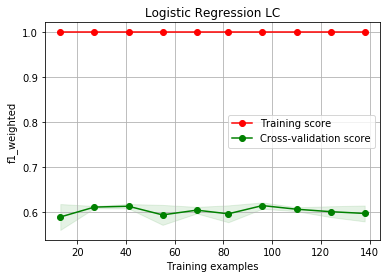

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

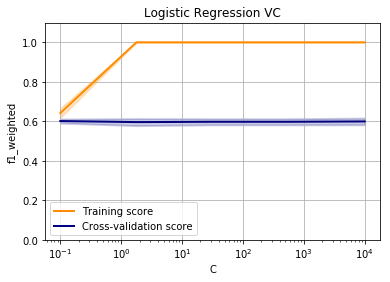

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

         -1       0.00      0.00      0.00        14
          0       0.68      1.00      0.81        71
          1       0.00      0.00      0.00        20

avg / total       0.46      0.68      0.55       105



F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

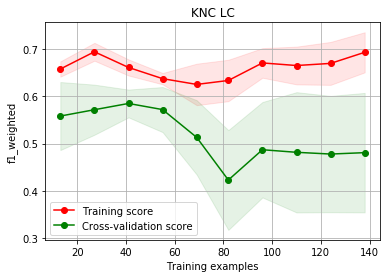

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

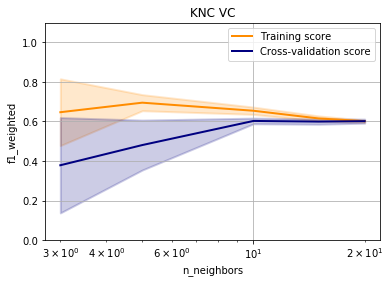

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

         -1       0.00      0.00      0.00        14
          0       0.68      1.00      0.81        71
          1       0.00      0.00      0.00        20

avg / total       0.46      0.68      0.55       105



F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

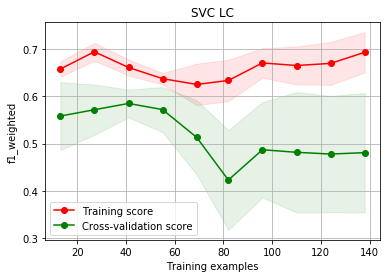

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

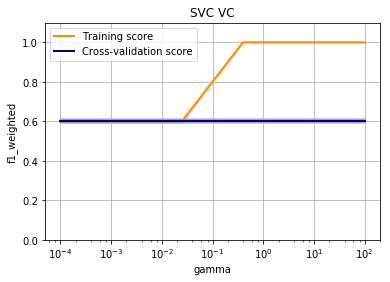

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

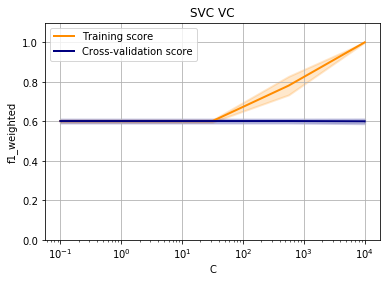

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

         -1       0.00      0.00      0.00        14
          0       0.68      1.00      0.81        71
          1       0.00      0.00      0.00        20

avg / total       0.46      0.68      0.55       105



F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

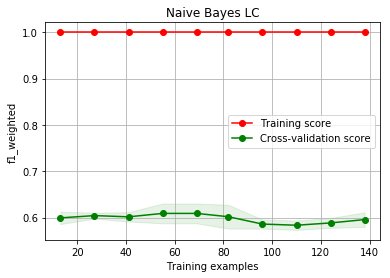

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

         -1       0.00      0.00      0.00        14
          0       0.67      0.99      0.80        71
          1       0.00      0.00      0.00        20

avg / total       0.46      0.67      0.54       105



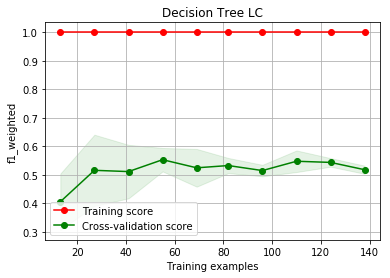

             precision    recall  f1-score   support

         -1       0.21      0.21      0.21        14
          0       0.68      0.76      0.72        71
          1       0.09      0.05      0.06        20

avg / total       0.50      0.55      0.52       105



F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

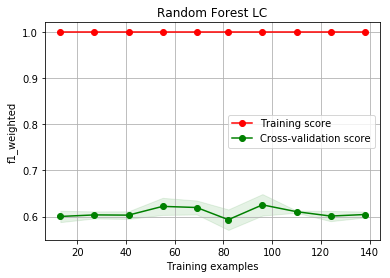

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

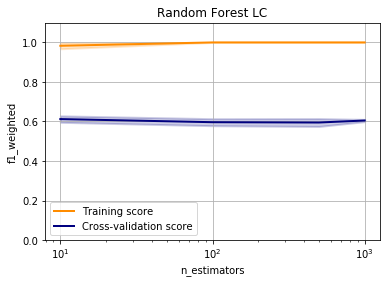

             precision    recall  f1-score   support

         -1       0.00      0.00      0.00        14
          0       0.68      1.00      0.81        71
          1       0.00      0.00      0.00        20

avg / total       0.46      0.68      0.55       105

                 Model  F1 Score: weighted                  Spread
0  Logistic Regression            0.545563                {0: 105}
1                  KNC            0.545563                {0: 105}
2                  SVC            0.545563                {0: 105}
3          Naive Bayes            0.540952         {0: 104, -1: 1}
4       Decision Trees            0.524493  {0: 80, -1: 14, 1: 11}
5        Random Forest            0.548680         {0: 104, -1: 1}
     Training Spread:      Counter({0: 80, -1: 14, 1: 11})
     Testing Spread:      Counter({0: 71, 1: 20, -1: 14})


F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [249]:
model('HINDZINC')

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

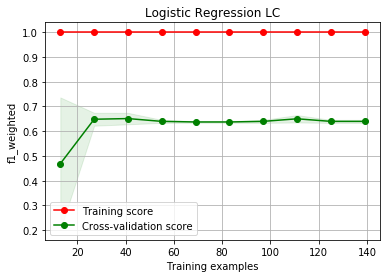

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

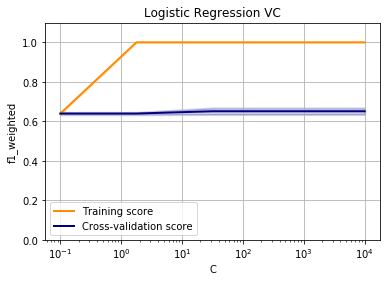

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

         -1       0.00      0.00      0.00        10
          0       0.73      1.00      0.85        77
          1       0.00      0.00      0.00        18

avg / total       0.54      0.73      0.62       105



F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

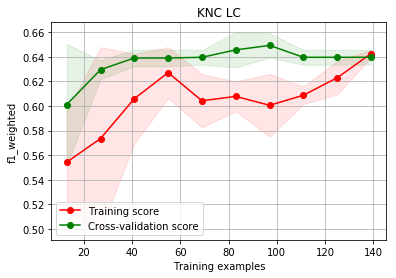

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

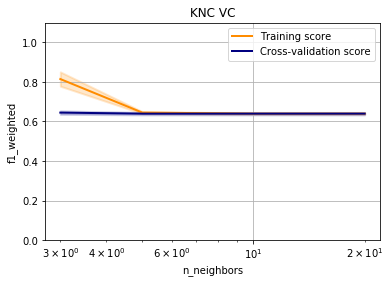

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

         -1       0.00      0.00      0.00        10
          0       0.73      1.00      0.85        77
          1       0.00      0.00      0.00        18

avg / total       0.54      0.73      0.62       105



F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

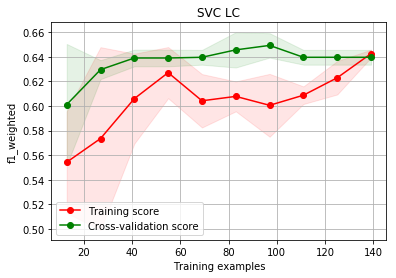

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

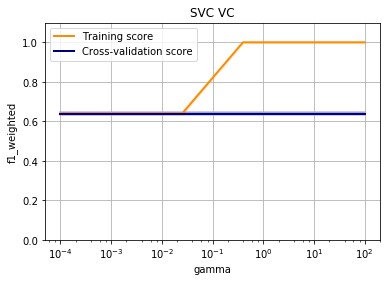

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

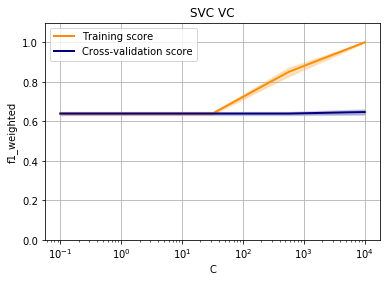

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

         -1       0.00      0.00      0.00        10
          0       0.73      1.00      0.85        77
          1       0.00      0.00      0.00        18

avg / total       0.54      0.73      0.62       105



F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

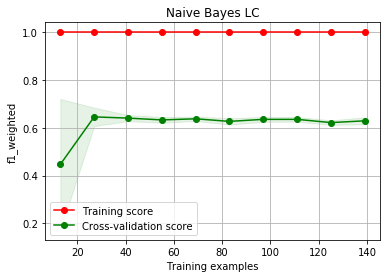

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

         -1       0.00      0.00      0.00        10
          0       0.73      1.00      0.85        77
          1       0.00      0.00      0.00        18

avg / total       0.54      0.73      0.62       105



F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


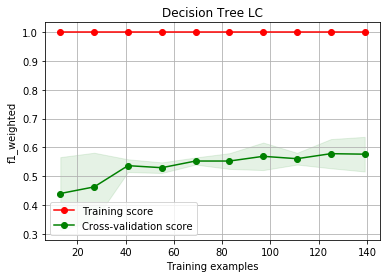

             precision    recall  f1-score   support

         -1       0.12      0.10      0.11        10
          0       0.75      0.74      0.75        77
          1       0.29      0.33      0.31        18

avg / total       0.61      0.61      0.61       105



F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

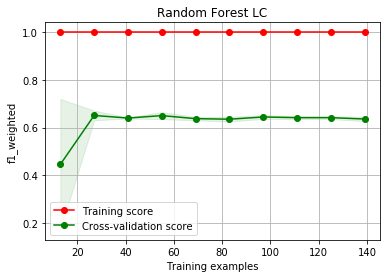

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

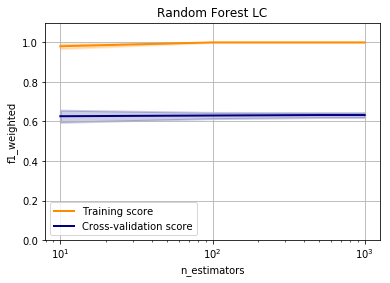

             precision    recall  f1-score   support

         -1       0.00      0.00      0.00        10
          0       0.73      1.00      0.85        77
          1       0.00      0.00      0.00        18

avg / total       0.54      0.73      0.62       105

                 Model  F1 Score: weighted                 Spread
0  Logistic Regression            0.620513               {0: 105}
1                  KNC            0.620513               {0: 105}
2                  SVC            0.620513               {0: 105}
3          Naive Bayes            0.620513               {0: 105}
4       Decision Trees            0.609734  {0: 76, 1: 21, -1: 8}
5        Random Forest            0.620513               {0: 105}
     Training Spread:      Counter({0: 80, 1: 20, -1: 5})
     Testing Spread:      Counter({0: 77, 1: 18, -1: 10})


F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [250]:
model('MRF')

The models perform poorly on both the above stocks.

Note: We use weighted f1 score as the model evaluation metric since most samples are classified as 0(hold).

Most models predict 0(hold) for all situations.

Decision Trees has a decent spread, however it has a low cross validation score.

The above results indicate a poor selection of features.

We use past 7 day momentum of all stocks as an indicator

In [7]:
nDays = 7

X = np.empty([daily_ret.shape[0]-nDays , daily_ret.shape[1]])

for row in range(daily_ret.shape[0]-nDays):
    for stk in range(daily_ret.shape[1]):
        temp = 1
        for day in range(nDays):
             temp = temp * (daily_ret.ix[row+day,stk]+1)
        
        X[row,stk] = temp-1

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

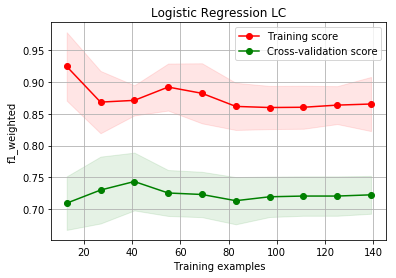

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

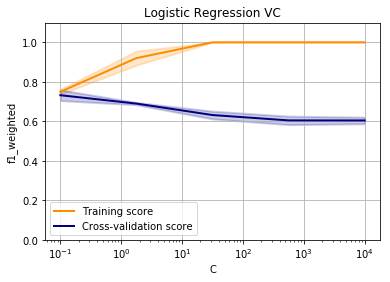

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\c

             precision    recall  f1-score   support

         -1       0.00      0.00      0.00        12
          0       0.83      1.00      0.91        87
          1       0.00      0.00      0.00         6

avg / total       0.69      0.83      0.75       105



F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

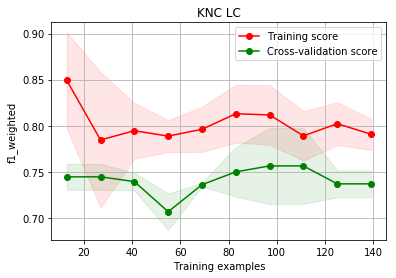

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

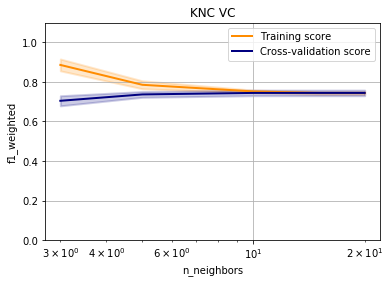

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\c

             precision    recall  f1-score   support

         -1       0.00      0.00      0.00        12
          0       0.83      0.99      0.90        87
          1       0.00      0.00      0.00         6

avg / total       0.69      0.82      0.75       105



F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

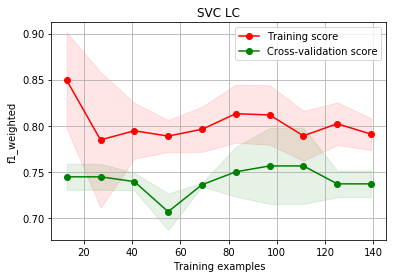

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

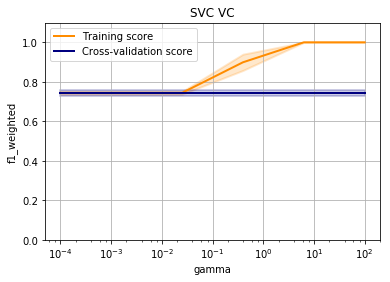

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

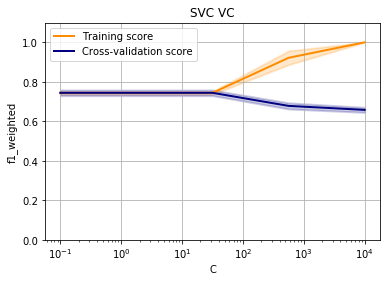

             precision    recall  f1-score   support

         -1       0.67      0.17      0.27        12
          0       0.88      0.89      0.88        87
          1       0.14      0.33      0.20         6

avg / total       0.81      0.77      0.77       105



F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

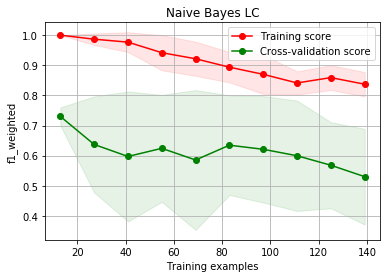

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

         -1       0.00      0.00      0.00        12
          0       0.84      0.82      0.83        87
          1       0.10      0.33      0.15         6

avg / total       0.70      0.70      0.69       105



F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


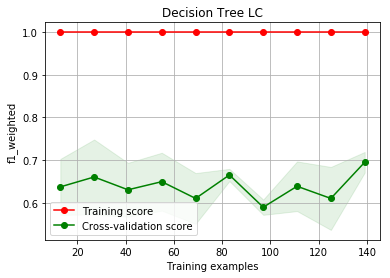

             precision    recall  f1-score   support

         -1       0.57      0.33      0.42        12
          0       0.88      0.68      0.77        87
          1       0.10      0.50      0.16         6

avg / total       0.80      0.63      0.69       105



F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

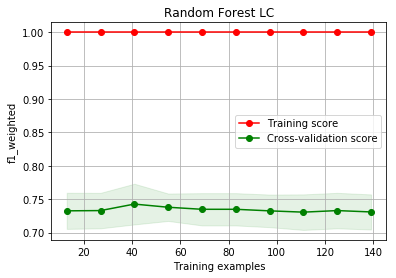

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

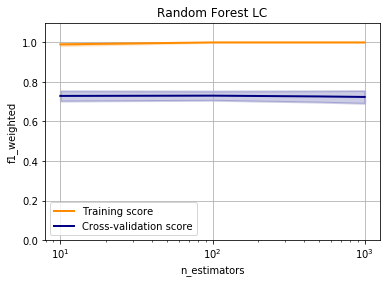

             precision    recall  f1-score   support

         -1       0.00      0.00      0.00        12
          0       0.84      0.98      0.90        87
          1       0.50      0.33      0.40         6

avg / total       0.73      0.83      0.77       105

                 Model  F1 Score: weighted                 Spread
0  Logistic Regression            0.750893               {0: 105}
1                  KNC            0.746148         {0: 104, 1: 1}
2                  SVC            0.771048  {0: 88, 1: 14, -1: 3}
3          Naive Bayes            0.692844         {0: 85, 1: 20}
4       Decision Trees            0.692266  {-1: 7, 0: 67, 1: 31}
5        Random Forest            0.772097         {0: 101, 1: 4}
     Training Spread:      Counter({0: 86, 1: 17, -1: 2})
     Testing Spread:      Counter({0: 87, -1: 12, 1: 6})


F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [19]:
model('ITC')

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

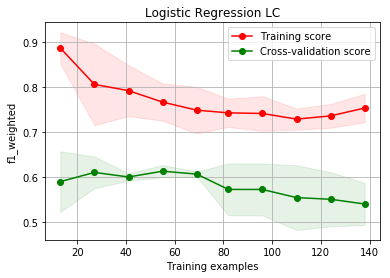

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

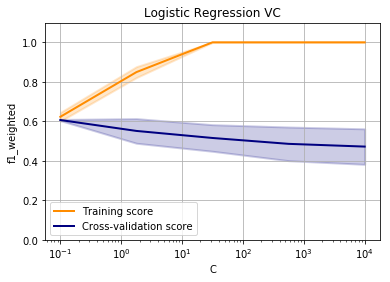

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\c

             precision    recall  f1-score   support

         -1       0.00      0.00      0.00        15
          0       0.70      1.00      0.83        74
          1       0.00      0.00      0.00        16

avg / total       0.50      0.70      0.58       105



F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

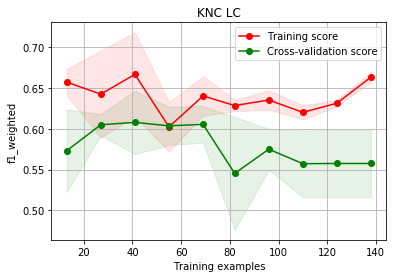

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

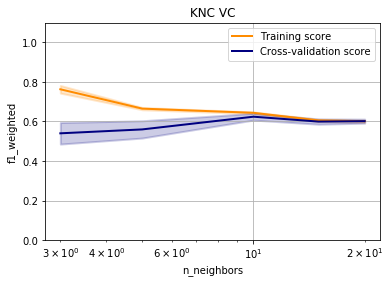

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\c

             precision    recall  f1-score   support

         -1       0.00      0.00      0.00        15
          0       0.70      0.99      0.82        74
          1       0.00      0.00      0.00        16

avg / total       0.49      0.70      0.58       105



F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

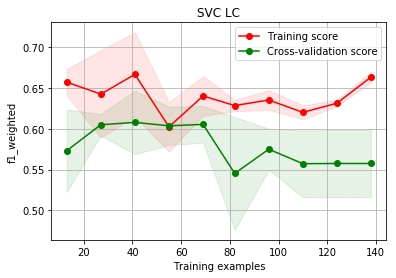

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

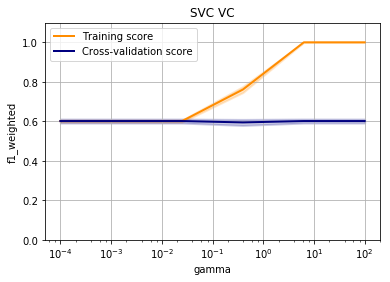

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

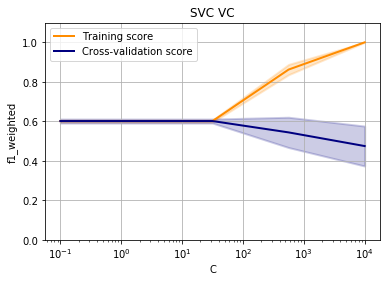

             precision    recall  f1-score   support

         -1       0.25      0.33      0.29        15
          0       0.71      0.69      0.70        74
          1       0.08      0.06      0.07        16

avg / total       0.55      0.54      0.54       105



F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

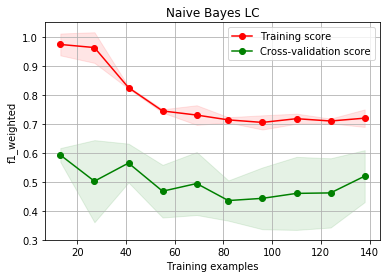

             precision    recall  f1-score   support

         -1       0.19      0.40      0.26        15
          0       0.67      0.45      0.54        74
          1       0.04      0.06      0.05        16

avg / total       0.51      0.38      0.42       105



F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


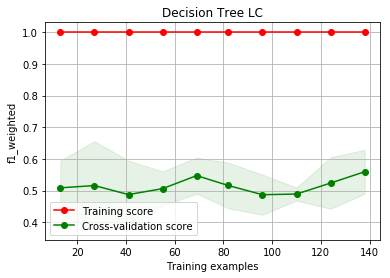

             precision    recall  f1-score   support

         -1       0.14      0.20      0.17        15
          0       0.71      0.68      0.69        74
          1       0.29      0.25      0.27        16

avg / total       0.57      0.54      0.55       105



F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

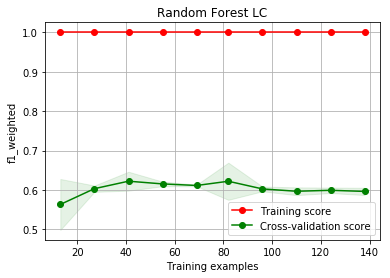

F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.p

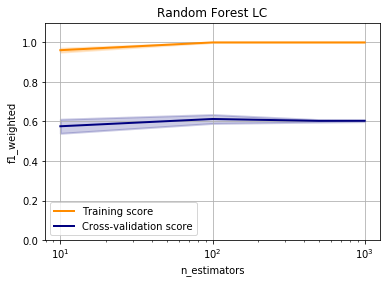

             precision    recall  f1-score   support

         -1       0.00      0.00      0.00        15
          0       0.70      0.99      0.82        74
          1       0.00      0.00      0.00        16

avg / total       0.49      0.70      0.58       105

                 Model  F1 Score: weighted                  Spread
0  Logistic Regression            0.582708                {0: 105}
1                  KNC            0.578063         {0: 104, -1: 1}
2                  SVC            0.543693  {0: 72, -1: 20, 1: 13}
3          Naive Bayes            0.422258  {0: 49, 1: 24, -1: 32}
4       Decision Trees            0.553862  {0: 70, -1: 21, 1: 14}
5        Random Forest            0.578063         {0: 104, -1: 1}
     Training Spread:      Counter({0: 77, 1: 15, -1: 13})
     Testing Spread:      Counter({0: 74, 1: 16, -1: 15})


F:\Software\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [20]:
model('HINDZINC')

The models perform poorly on both the above stocks.

Unlike the above model, this model does identify buy and sell opportunities however with really bad accuracy

Decision Trees has a decent spread, however it has a low cross validation score.

The above results indicate a poor selection of features.